## Team 7: Online News Popularity

**Dataset Information**: (http://archive.ics.uci.edu/ml/datasets/Online+News+Popularity)

The articles were published by Mashable (www.mashable.com) and their content as the rights to reproduce it belongs to them. Hence, this dataset does not share the original content but some statistics associated with it. The original content be publicly accessed and retrieved using the provided urls. Acquisition date: January 8, 2015 

The estimated relative performance values were estimated by the authors using a Random Forest classifier and a rolling windows as assessment method. See their article for more details on how the relative performance values were set.

Objective: **predict the number of shares in social networks (popularity)**.

**Attribute Information**:

Number of Attributes: 61 (58 predictive attributes, 2 non-predictive, 1 goal field) 

In [14]:
# Import Libaries
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pprint import pprint as pp

warnings.filterwarnings('ignore')

from tqdm import tqdm_notebook, tnrange
tqdm_notebook().pandas()

# Define Graph Styles
sns.set_style('darkgrid')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
d_fontsize = 20
d_figsize = (20,8)
sns.set(rc={'figure.figsize': d_figsize})
target_name = 'Number of Shares'

# Load Data as DataFrame
csv_path = './datasets/OnlineNewsPopularity.csv'
df = pd.read_csv(csv_path)

<div class="alert alert-info" style="font-size:150%"><b>1. Clean Data</b></div>

In [17]:
# Remove Weird Spaces From Column Names
df.columns = df.columns.map(lambda x: x.replace(' ', ''))

In [18]:
# Convert Columns to Correct Data Types
boolean_columns = [column_name for column_name in df.columns if 'is' in column_name]
df[boolean_columns] = df[boolean_columns].astype(bool)

'''
['data_channel_is_lifestyle',
 'data_channel_is_entertainment',
 'data_channel_is_bus',
 'data_channel_is_socmed',
 'data_channel_is_tech',
 'data_channel_is_world',
 'weekday_is_monday',
 'weekday_is_tuesday',
 'weekday_is_wednesday',
 'weekday_is_thursday',
 'weekday_is_friday',
 'weekday_is_saturday',
 'weekday_is_sunday',
 'is_weekend']
 '''

int_columns = [
    'timedelta', # Days between the article publication and the dataset acquisition
    'n_tokens_title', # Number of words in the title
    'n_tokens_content', # Number of words in the content
    'num_hrefs', # Number of links
    'num_self_hrefs', # Number of links to other articles
    'num_imgs', # Number of images
    'num_videos', # Number of videos
    'num_keywords', # Number of keywords in the metadata
    'self_reference_min_shares', # Min. shares of referenced articles in Mashable
    'self_reference_max_shares', # Max. shares of referenced articles in Mashable
]

df[int_columns] = df[int_columns].astype('int64')

<div class="alert alert-info" style="font-size:150%"><b>2. EDA</b></div>

In [19]:
print('There are {num_articles} articles'.format(num_articles = len(df)))

There are 39644 articles


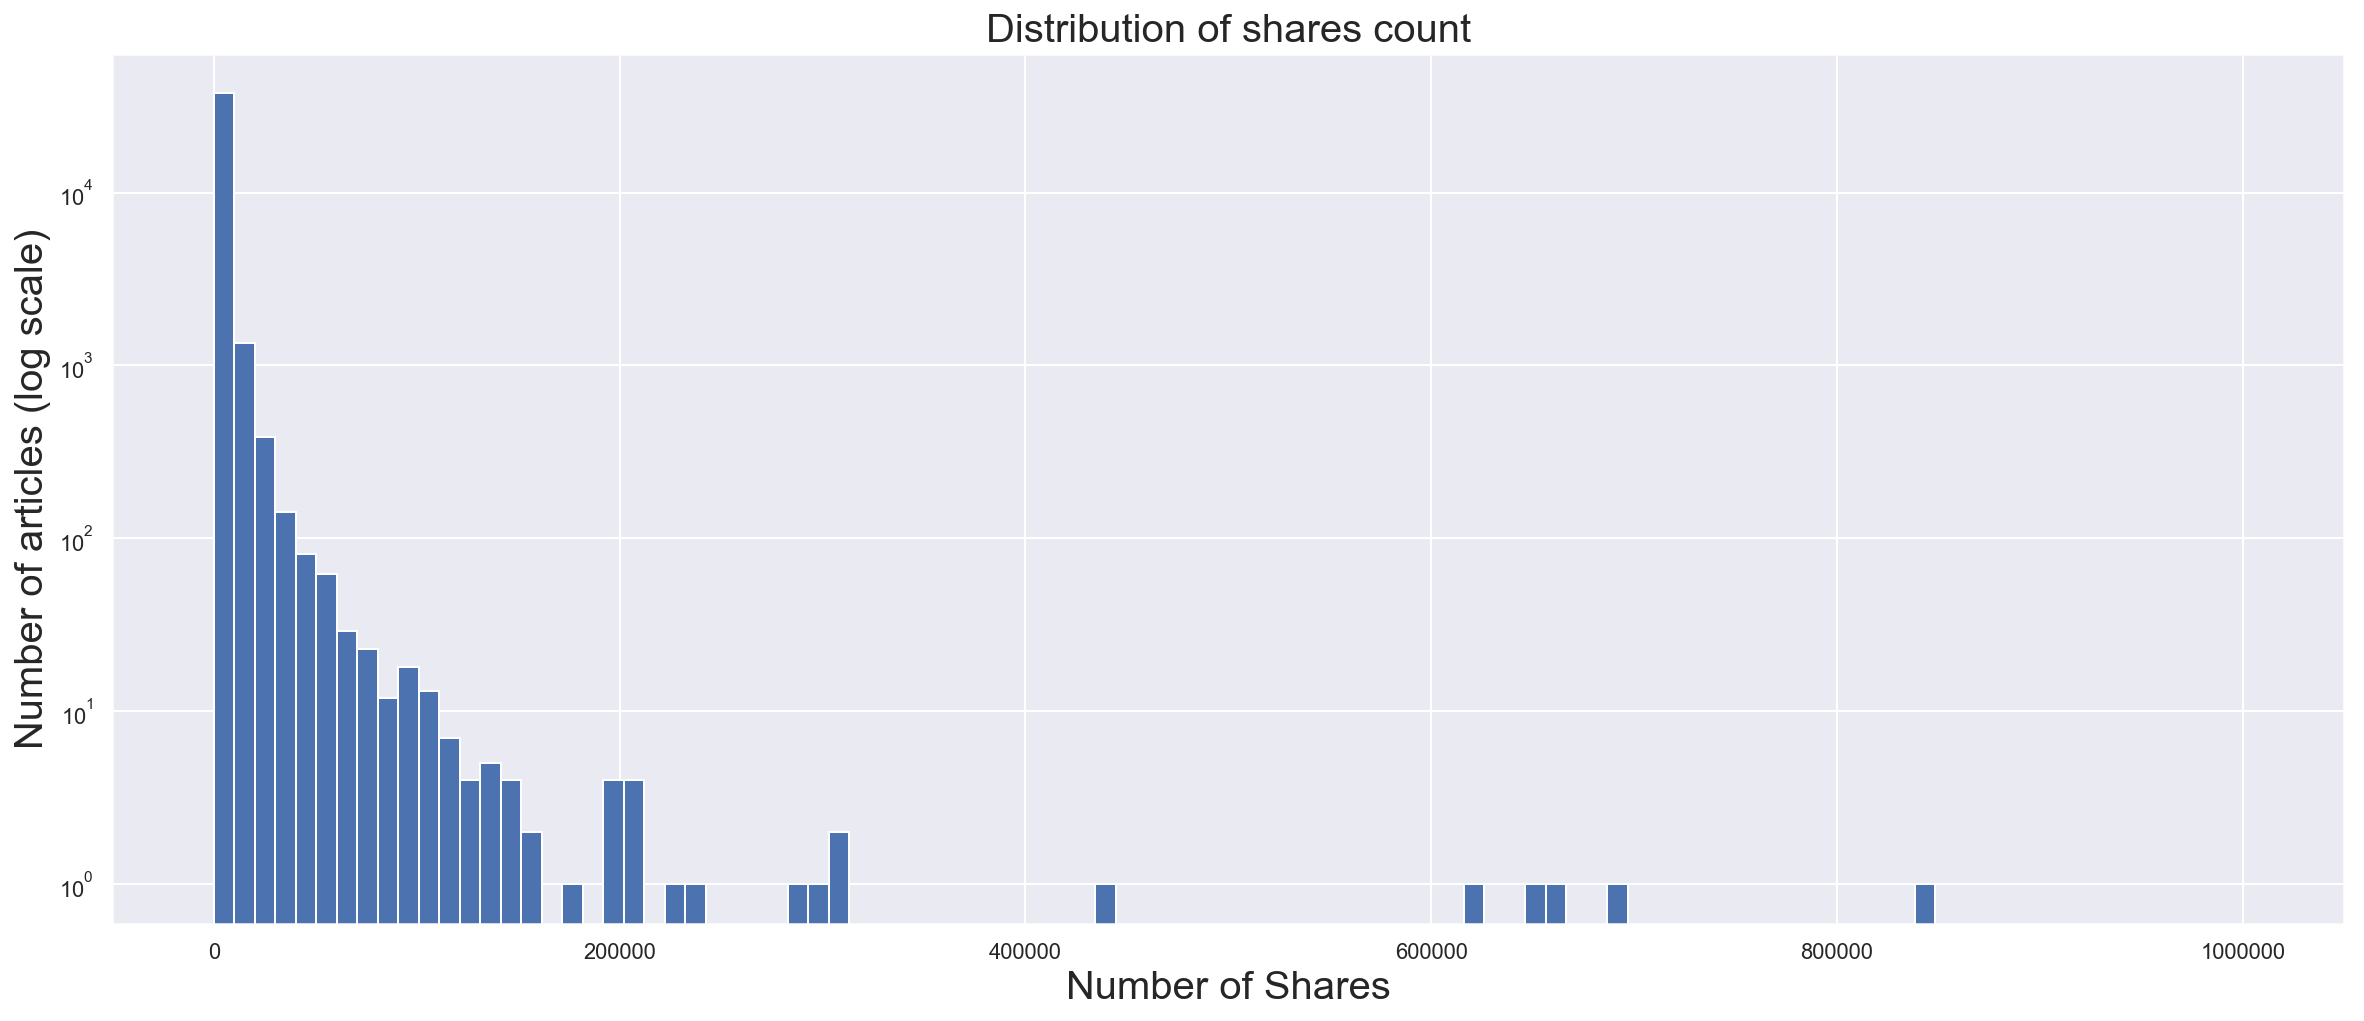

In [20]:
def plot_distribution_of_target_variable():
    plot_data = df['shares']
    fig = plt.figure(figsize=(20,8))
    ax = fig.gca()
    ax.set_yscale('log')
    ax.set_title('Distribution of shares count', fontsize = d_fontsize)
    ax.set_xlabel(target_name, fontsize = d_fontsize)
    ax.set_ylabel('Number of articles (log scale)', fontsize = d_fontsize)
    ax.hist(plot_data, bins = np.linspace(0, 10**6, 10**2));
plot_distribution_of_target_variable()

<div class="alert alert-info" style="font-size:150%"><u>Feature Engineering</u><br/>Even with y-axis on log scale, distribution of shares count is still extremely skewed to the right. Thus, we create alternative target variables: <b>target_p50</b>, <b>target_p90</b> and <b>target_categories</b>.</div>

In [21]:
shares_p50 = df['shares'].quantile(0.5)
shares_p50

1400.0

<div class="alert alert-info" style="font-size:150%"><b>target_p50</b>: Instead of predicting share count, we predict whether an article will go viral, with the defintion of viral being more than 1400 shares (50th percentile)</div>

In [22]:
df['target_p50'] = df['shares'].map(lambda x : 1 if x > shares_p50 else 0)
df[['shares', 'target_p50']].head()

,shares,target_p50
0,593,0
1,711,0
2,1500,1
3,1200,0
4,505,0


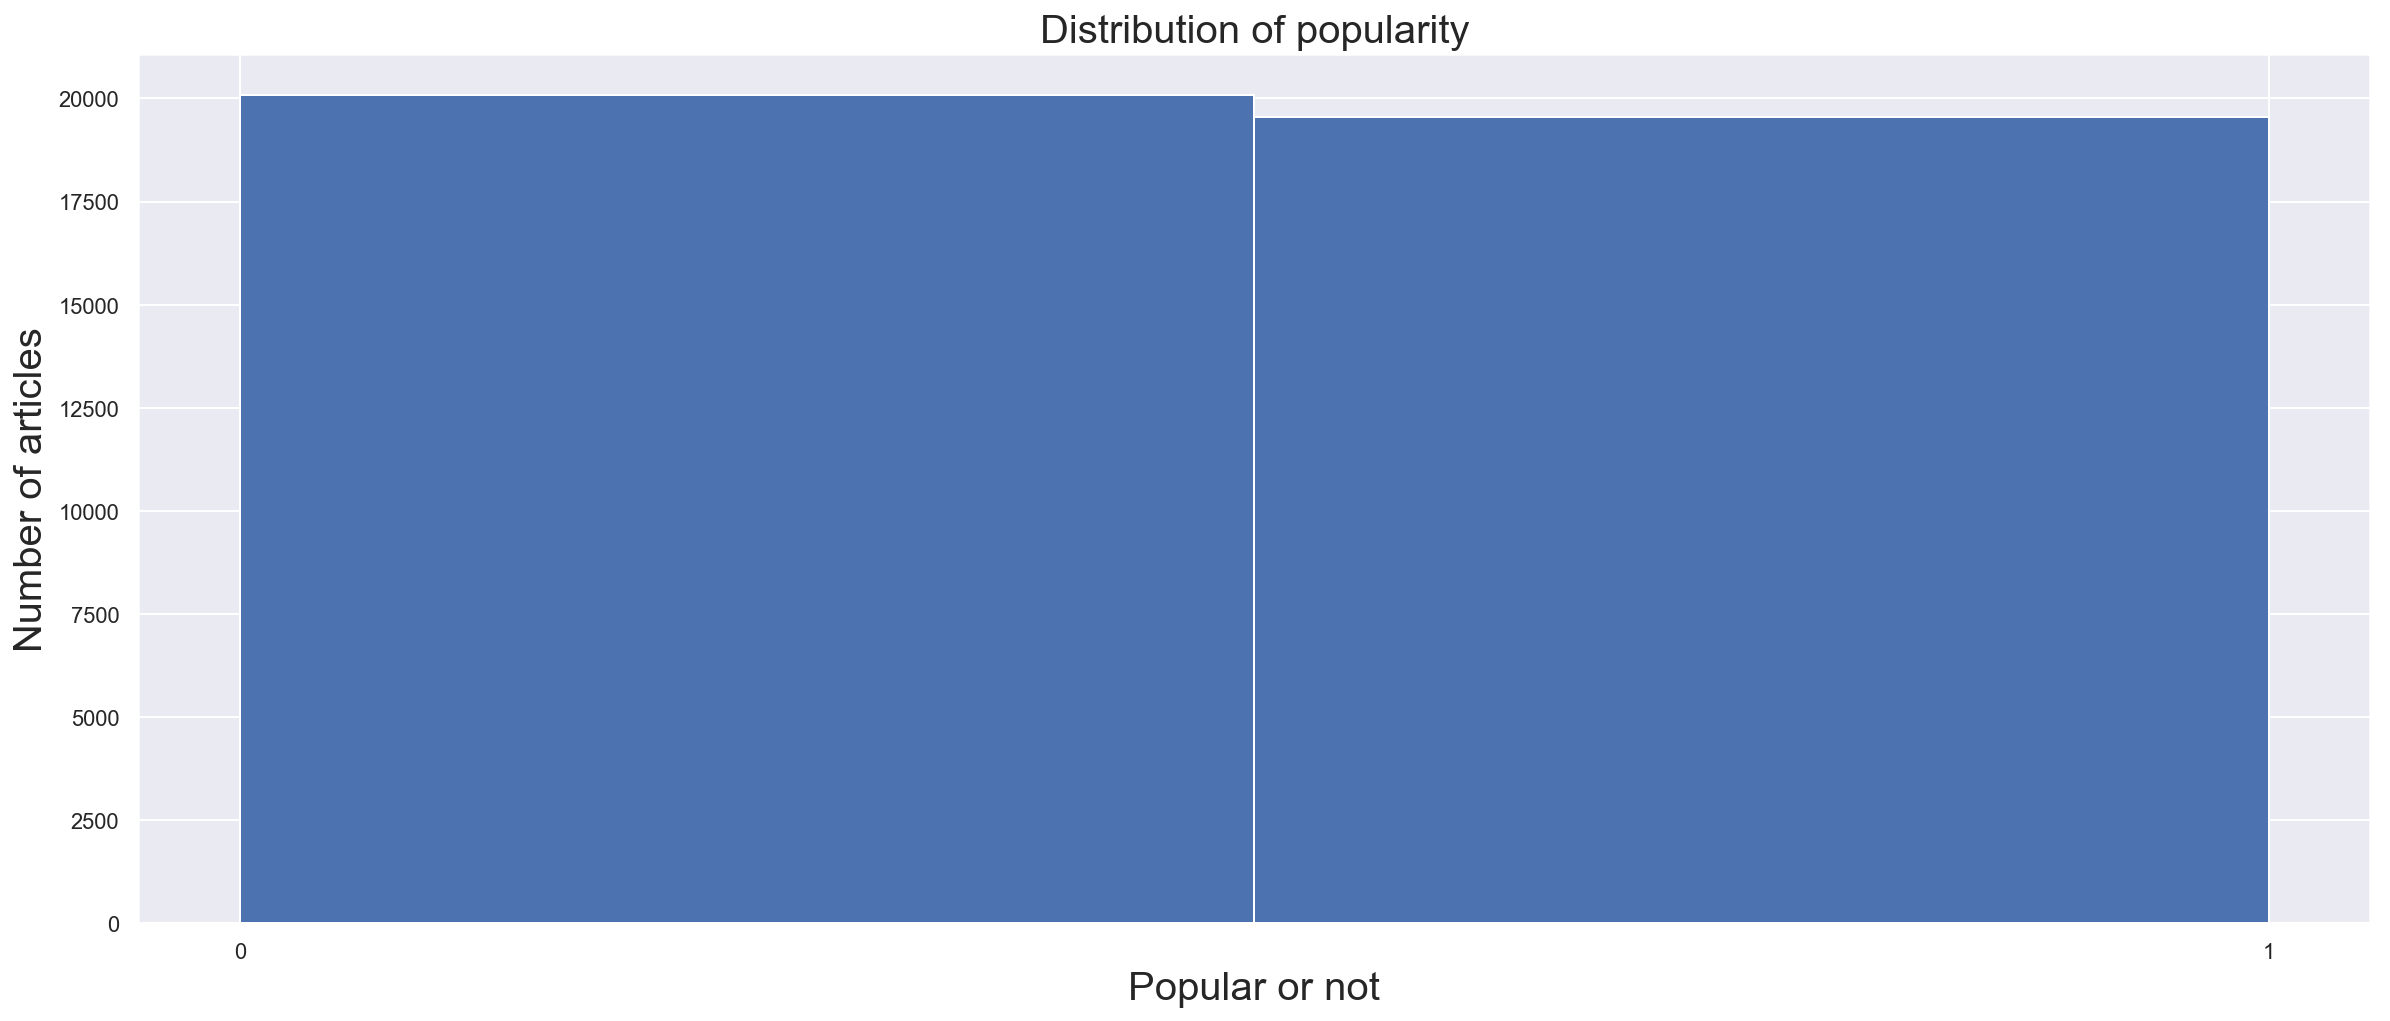

In [23]:
def plot_pop_distribution():
    plot_data = df['target_p50']
    fig = plt.figure(figsize=(20,8))
    ax = fig.gca()
    ax.set_title('Distribution of popularity', fontsize = d_fontsize)
    ax.set_xlabel('Popular or not', fontsize = d_fontsize)
    ax.set_xticks([0,1])
    ax.set_ylabel('Number of articles', fontsize = d_fontsize)
    ax.hist(plot_data, bins=2);
plot_pop_distribution()

In [24]:
shares_p90 = df['shares'].quantile(0.9)
shares_p90

6200.0

<div class="alert alert-info" style="font-size:150%"><b>target_p90</b>: Instead of predicting share count, we predict whether an article will go viral, with the defintion of viral being more than 6200 shares (90th percentile)</div>

In [25]:
df['target_p90'] = df['shares'].map(lambda x : 1 if x > shares_p90 else 0)
df[['shares', 'target_p90']].head()

,shares,target_p90
0,593,0
1,711,0
2,1500,0
3,1200,0
4,505,0


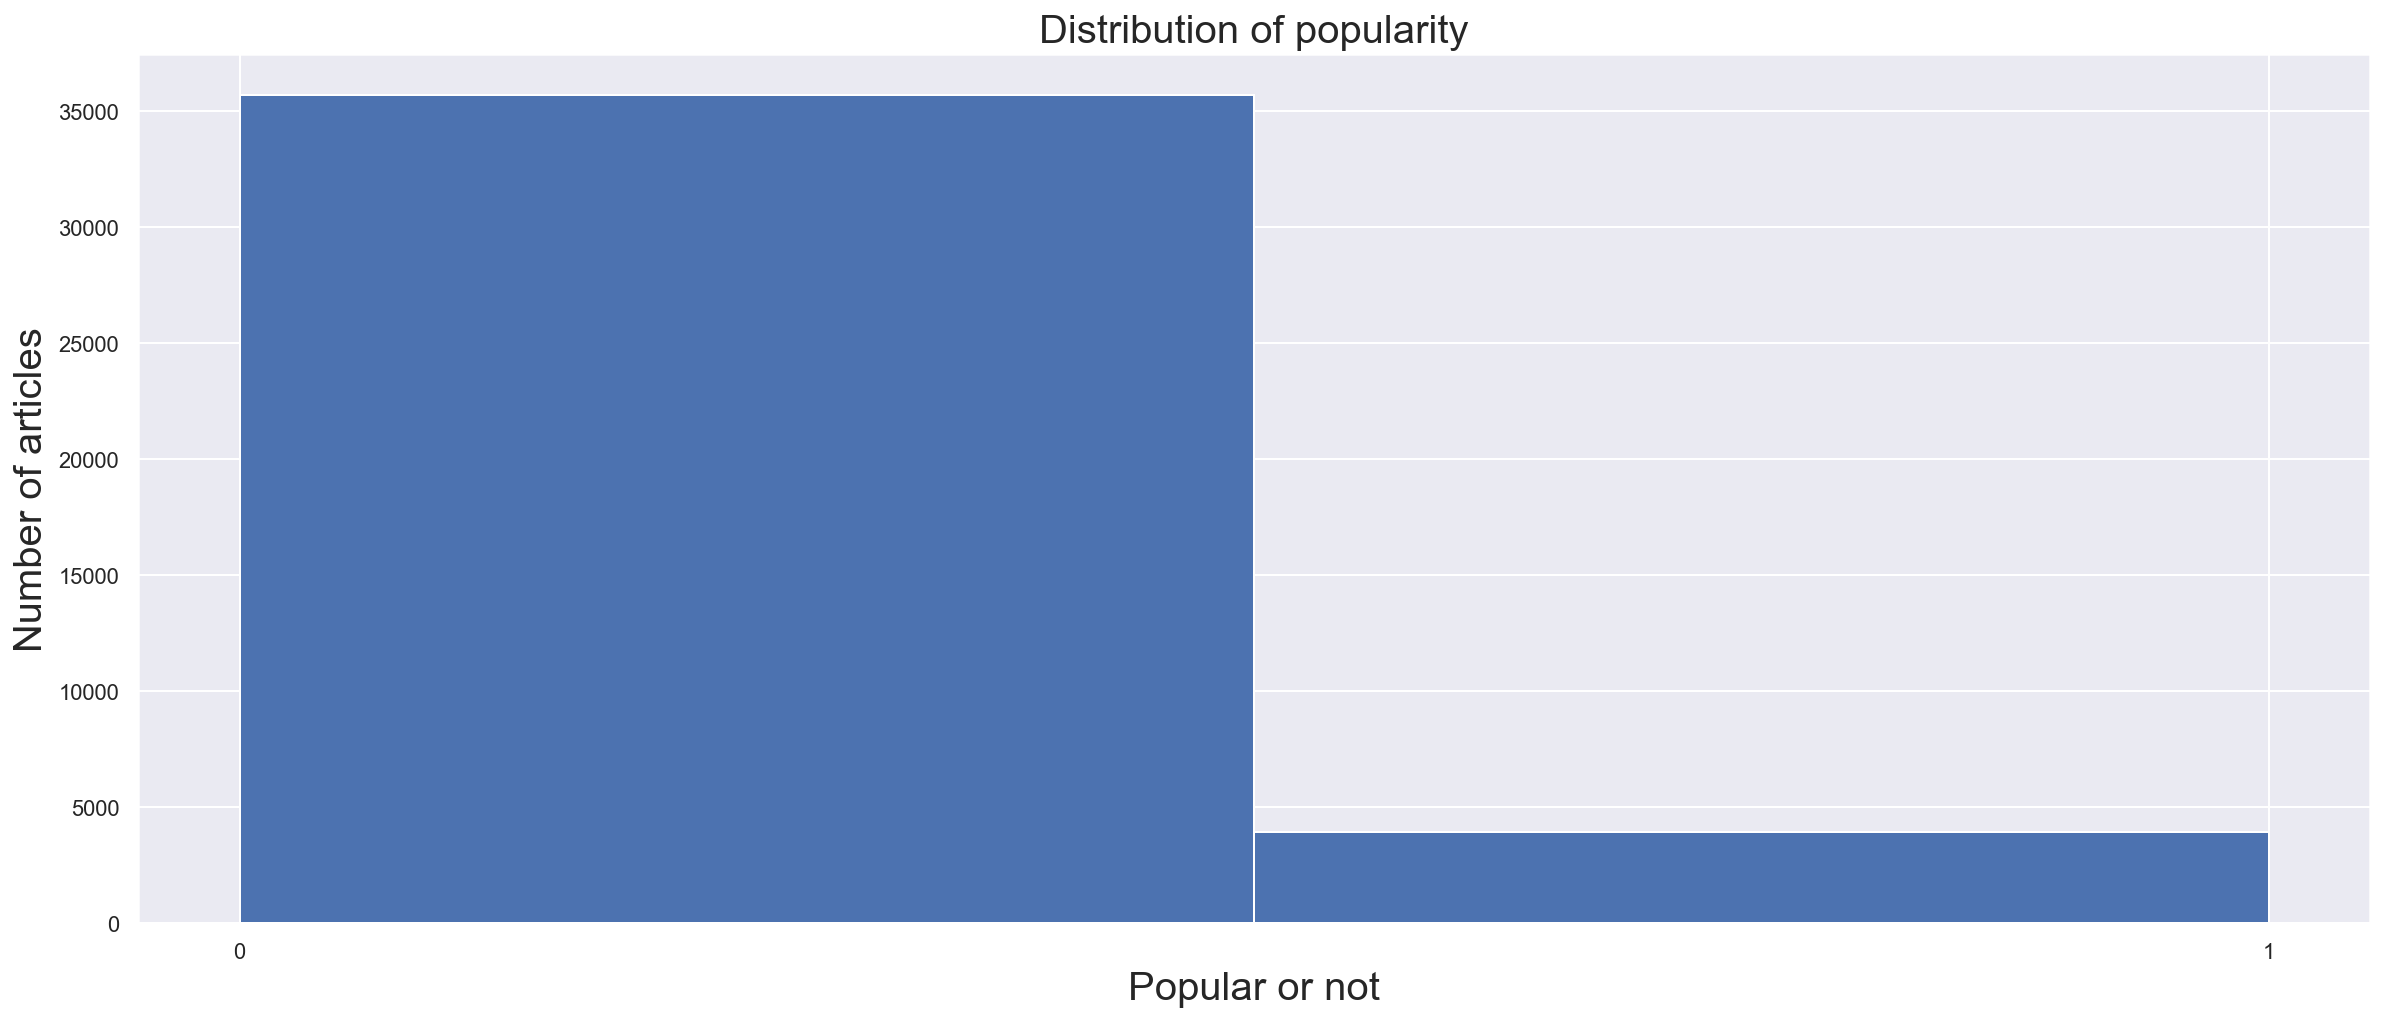

In [26]:
def plot_pop_distribution():
    plot_data = df['target_p90']
    fig = plt.figure(figsize=(20,8))
    ax = fig.gca()
    ax.set_title('Distribution of popularity', fontsize = d_fontsize)
    ax.set_xlabel('Popular or not', fontsize = d_fontsize)
    ax.set_xticks([0,1])
    ax.set_ylabel('Number of articles', fontsize = d_fontsize)
    ax.hist(plot_data, bins=2);
plot_pop_distribution()

<div class="alert alert-info" style="font-size:150%"><b>target_categories</b>: Instead of predicting share count, we predict whether an article's share count will be within the 1st - 25th percentile, 25th - 50th percentile, 50th - 75th percentile of 75th - 99th percentile.</div>

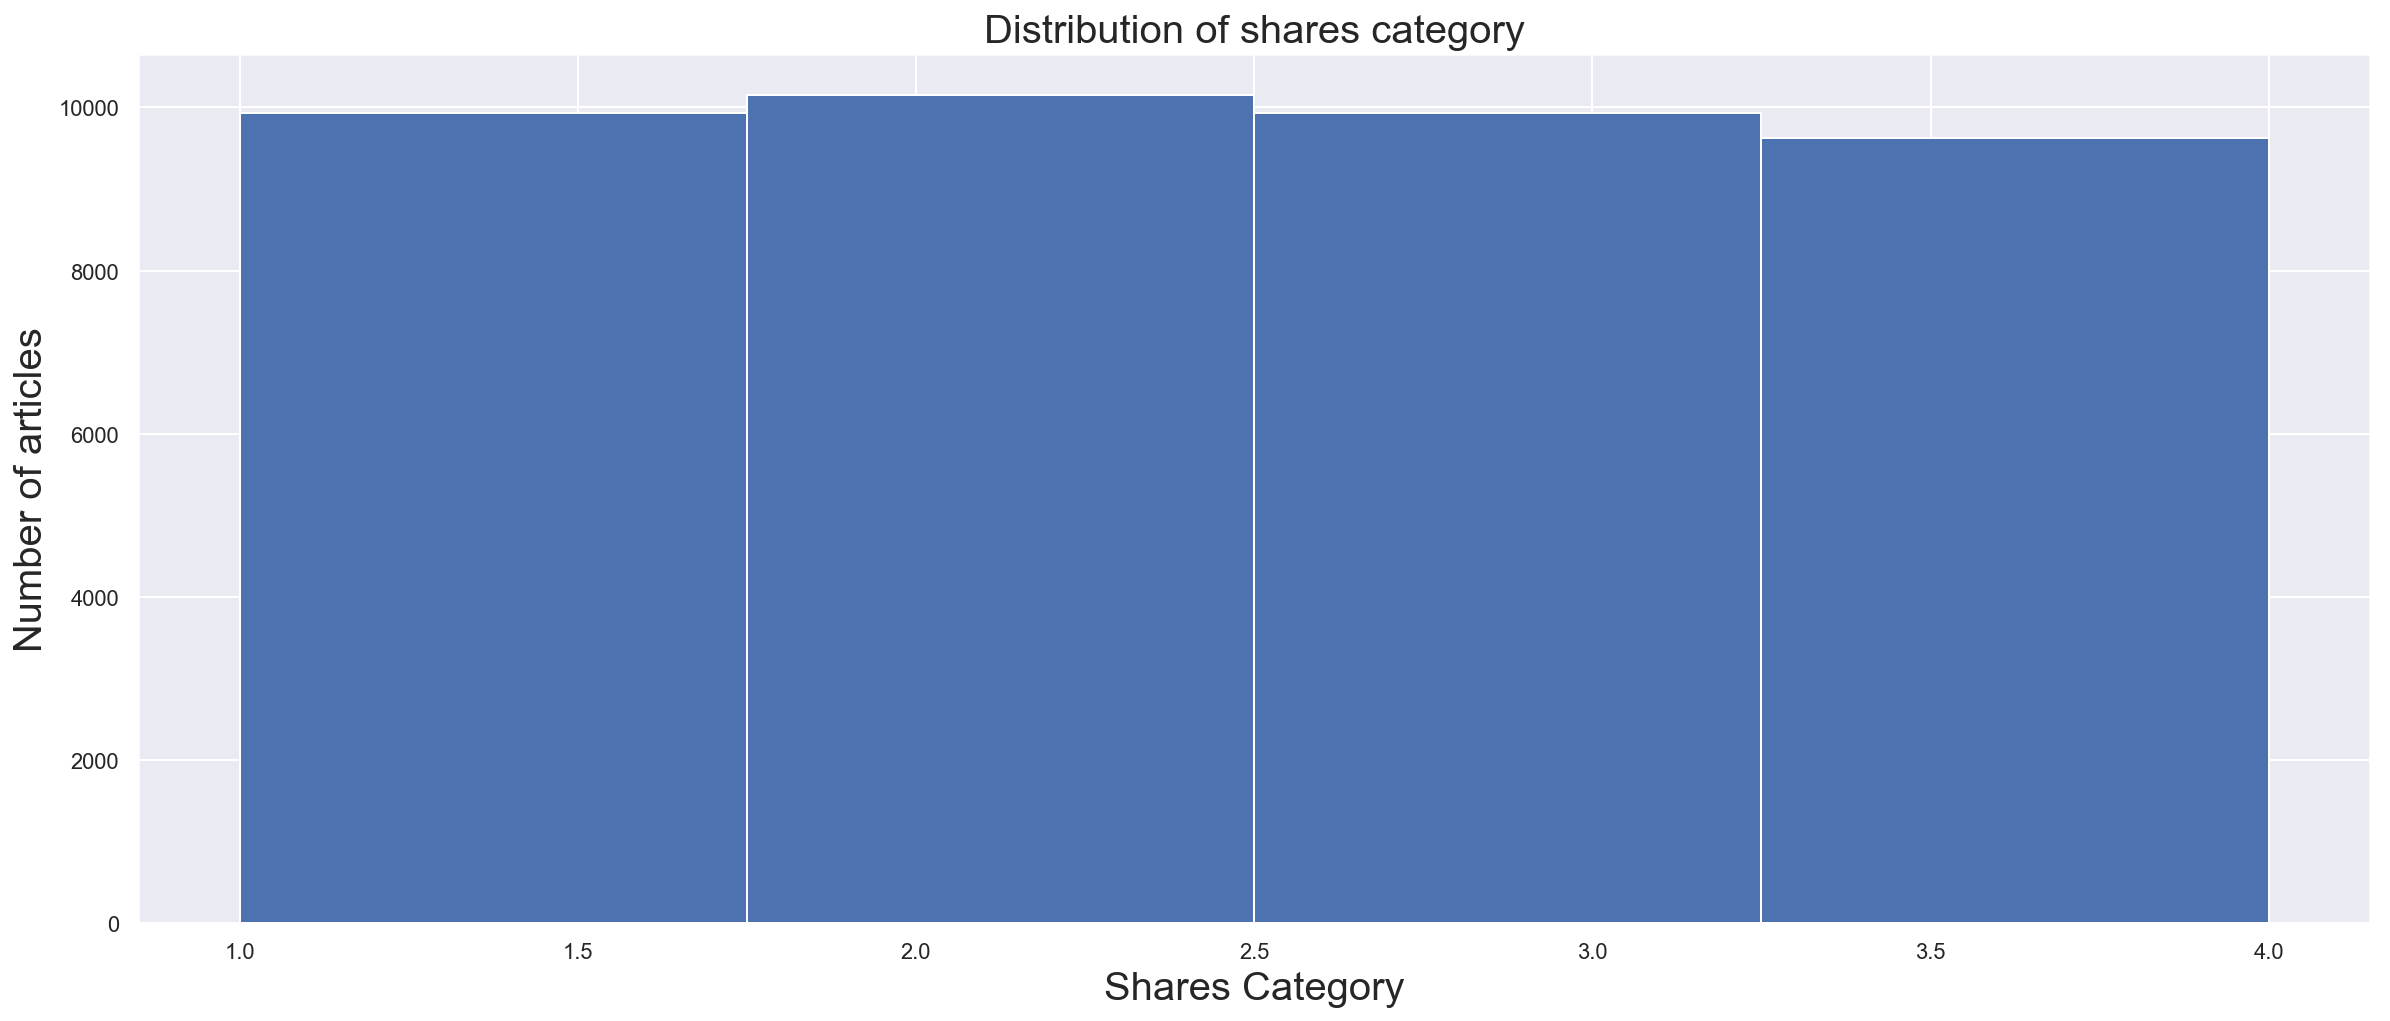

In [27]:
p_25 = df['shares'].quantile(0.25)
p_50 = df['shares'].quantile(0.50)
p_75 = df['shares'].quantile(0.75)
df['target_categories'] = df['shares'].apply(lambda x: 4 if x > p_75 else (3 if x > p_50 else (2 if x > p_25 else 1)))
def plot_shares_cat_distribution():
    plot_data = df['target_categories']
    fig = plt.figure(figsize=(20,8))
    ax = fig.gca()
    ax.set_title('Distribution of shares category', fontsize = d_fontsize)
    ax.set_xlabel('Shares Category', fontsize = d_fontsize)
    ax.set_ylabel('Number of articles', fontsize = d_fontsize)
    ax.hist(plot_data, bins=4);
plot_shares_cat_distribution()

<div class="alert alert-info" style="font-size:150%"><b>Interesting Visualisation: Social Media shares by Day of the Week</b></div>

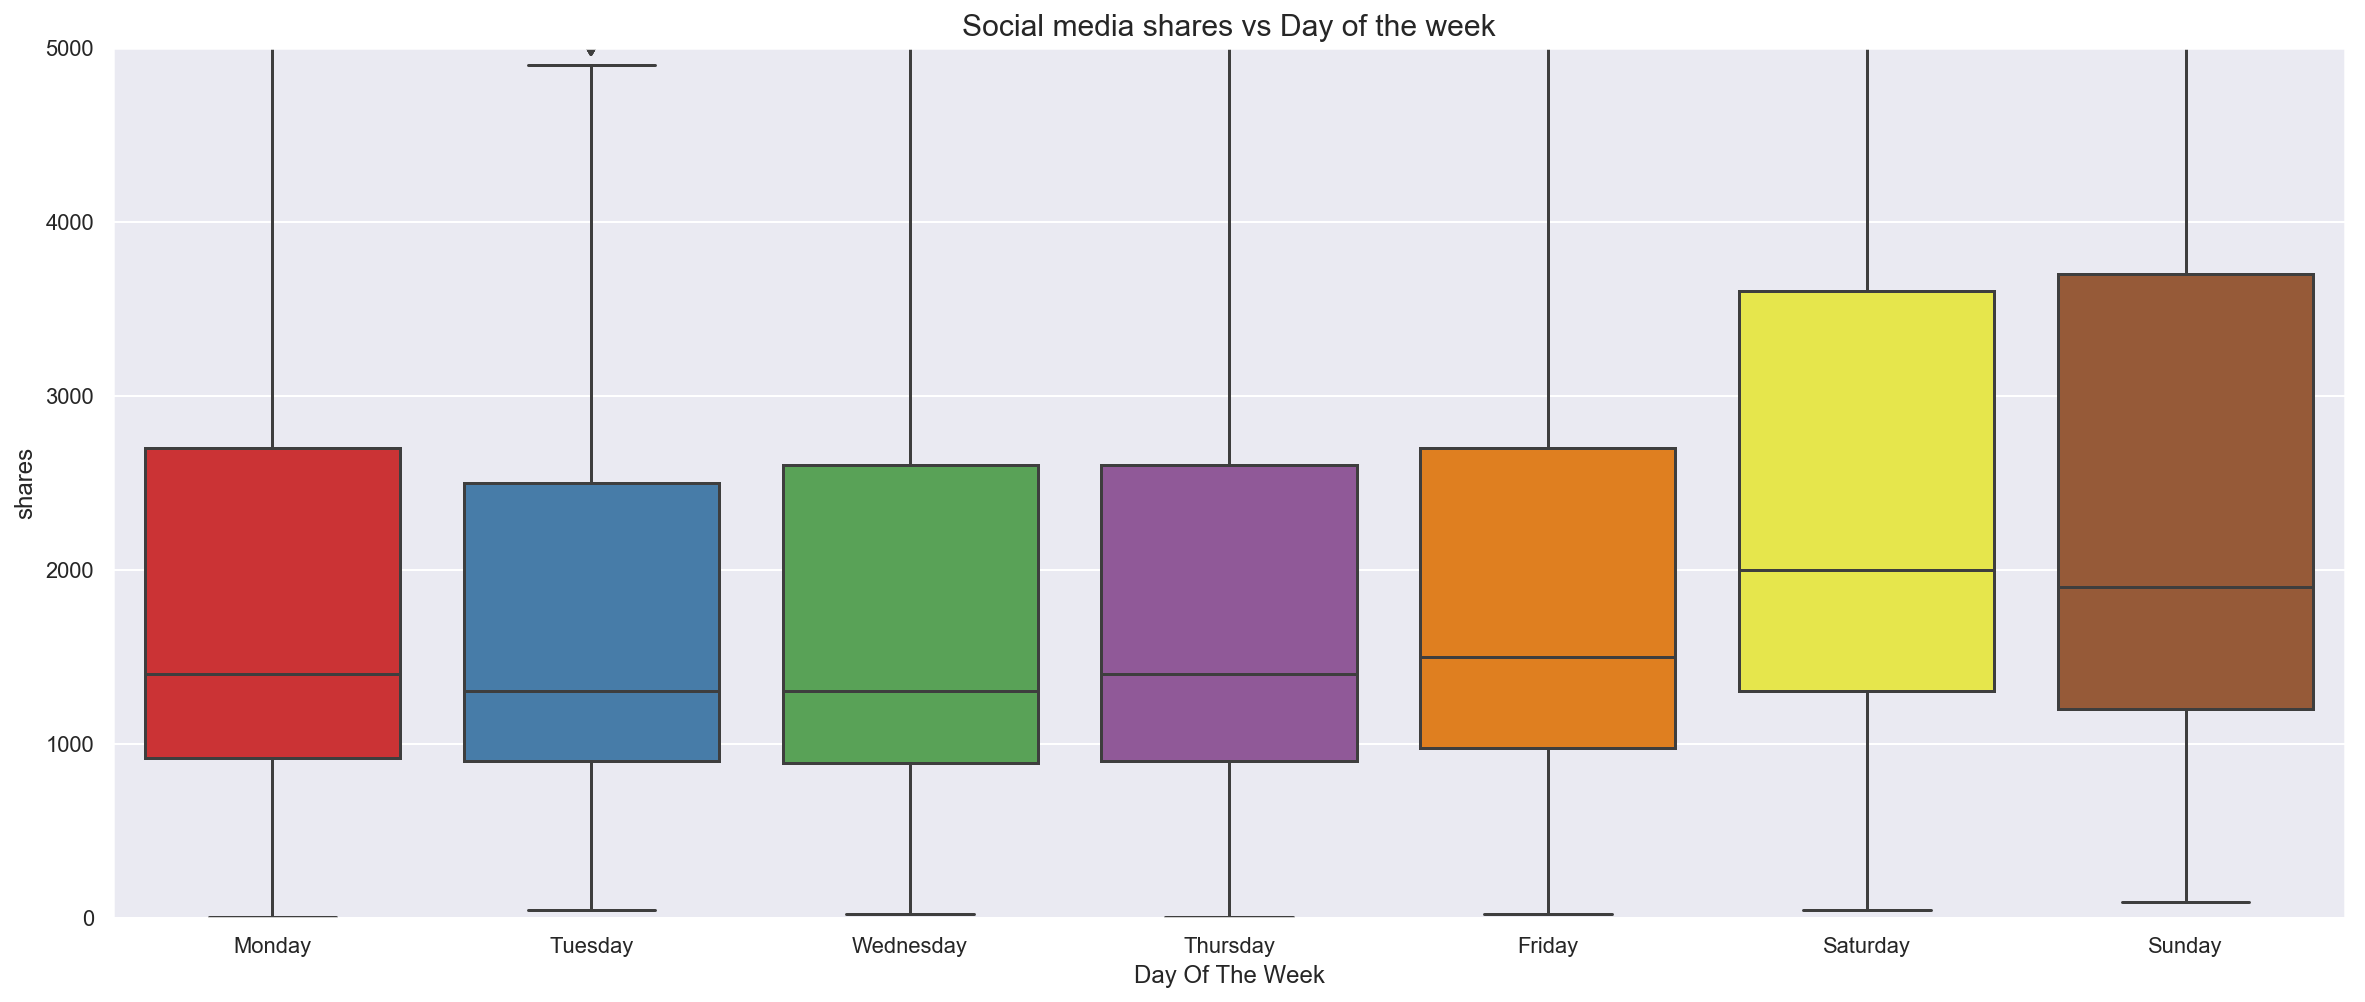

In [28]:
# combining weekday dummy variables into single column only to plot graph

dotw = {}
dotw['Monday'] = df['weekday_is_monday']
dotw['Tuesday'] = df['weekday_is_tuesday']
dotw['Wednesday'] = df['weekday_is_wednesday']
dotw['Thursday'] = df['weekday_is_thursday']
dotw['Friday'] = df['weekday_is_friday']
dotw['Saturday'] = df['weekday_is_saturday']
dotw['Sunday'] = df['weekday_is_sunday']

dotw = pd.DataFrame(dotw)

def get_weekday(row):
    for c in dotw.columns:
        if row[c]==1:
            return c

dotw = dotw.apply(get_weekday, axis=1)

df1 = pd.concat([df, dotw],axis=1)
df1.rename(columns={0:'Day Of The Week'},inplace=True)

plt.figure(figsize=(20,8))
sns.boxplot(data=df1, x='Day Of The Week',y='shares',\
            palette='Set1')
ax = plt.gca()
ax.set_ylim([0, 5000])  
ax.set_title("Social media shares vs Day of the week",size=15);


<div class="alert alert-info" style="font-size:150%"><b>3. Correlation with Target</b></div>

In [39]:
# linear correlation
df_without_y = df[[x for x in df.columns if x not in ['target_categories', 'target_p50', 'target_p90']]]
top_correlated = df_without_y.corr(method = 'spearman')['shares'].abs().sort_values()[::-1]
predictors_t5 = list(top_correlated[1:6].keys())
predictors_t10 = list(top_correlated[1:11].keys())
predictors_all = list(top_correlated[1::].keys())

predictors_t5

['kw_avg_avg',
 'kw_max_avg',
 'self_reference_avg_sharess',
 'self_reference_min_shares',
 'self_reference_max_shares']

<div class="alert alert-info" style="font-size:150%">These are the top 5 predictor variables with strong linear correlation. </div>

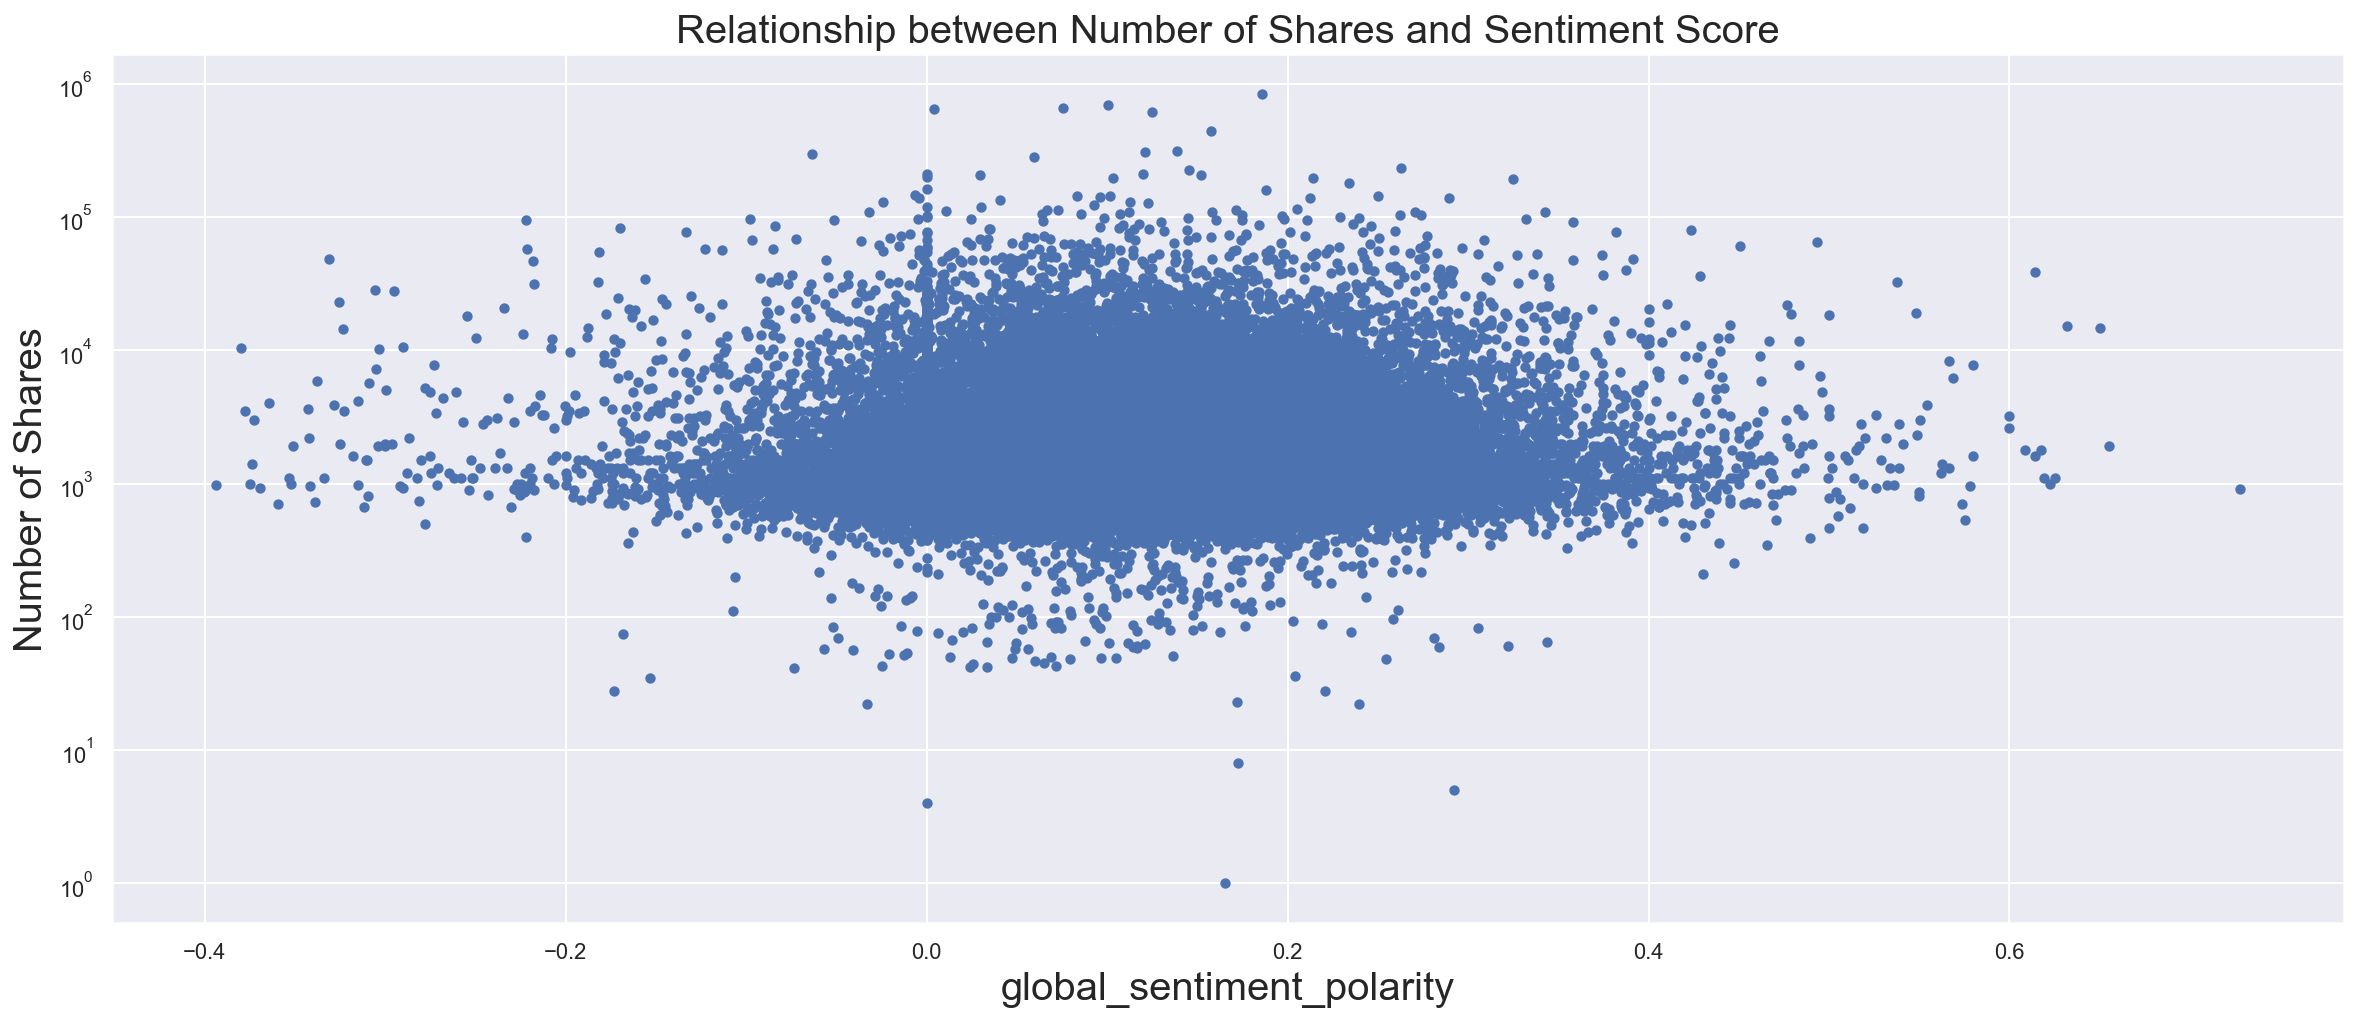

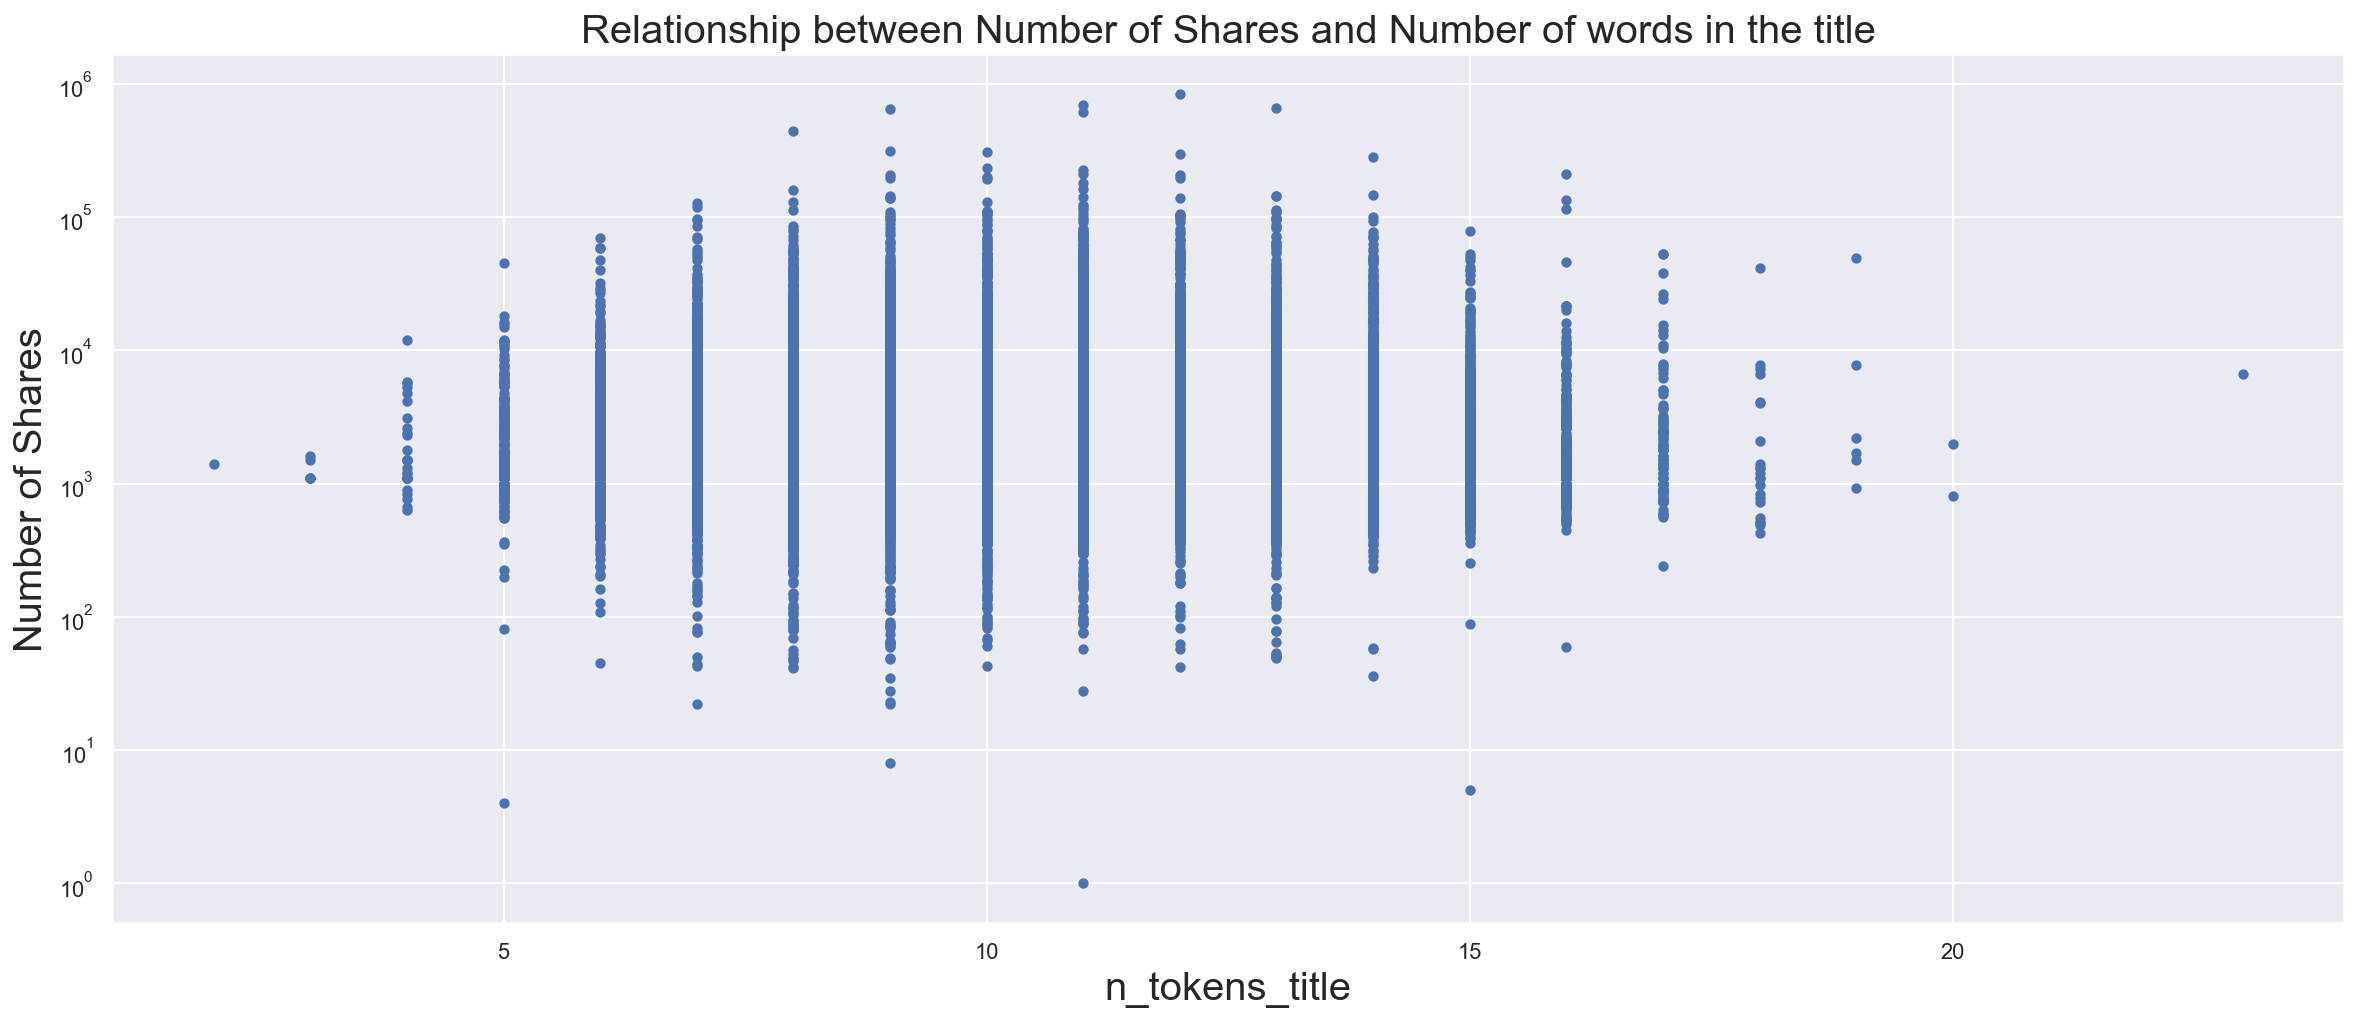

In [40]:
# non-linear correlation
non_linear_corr_vars = [
    'global_sentiment_polarity',
    'n_tokens_title', 
]

non_linear_corr_names = {
    'global_sentiment_polarity': 'Sentiment Score',
    'n_tokens_title': 'Number of words in the title'
}

for column_name in non_linear_corr_vars:
    fig = plt.figure(figsize=(20,8))
    ax = fig.gca()
    ax.set_yscale('log')
    ax.scatter(x = df[column_name], y = df['shares'], s = 10, linewidths = 2);
    ax.set_title('Relationship between {y} and {x}'.format(
        x = non_linear_corr_names[column_name], 
        y = target_name
    ), 
    fontsize = d_fontsize)
    ax.set_ylabel(target_name, fontsize = d_fontsize)
    ax.set_xlabel(column_name, fontsize = d_fontsize)
    plt.show()

<div class="alert alert-info" style="font-size:150%">Articles with 
<li>a neutral to slightly positive tone, and</li>
<li>title containing 7 to 13 words</li>
has higher share counts. </div>

<div class="alert alert-info" style="font-size:150%"><b>4. Seperate into predictors and target values</b></div>

In [31]:
df_predictors = df[[x for x in df.columns if x not in ['url', 'target_p50', 'target_p90', 'target_categories']]]
df_predictors.head()

,timedelta,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,num_videos,...,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,shares
0,731,12,219,0.663594,1.0,0.815385,4,2,1,0,...,0.100000,0.7,-0.350000,-0.600,-0.200000,0.500000,-0.187500,0.000000,0.187500,593
1,731,9,255,0.604743,1.0,0.791946,3,1,1,0,...,0.033333,0.7,-0.118750,-0.125,-0.100000,0.000000,0.000000,0.500000,0.000000,711
2,731,9,211,0.575130,1.0,0.663866,3,1,1,0,...,0.100000,1.0,-0.466667,-0.800,-0.133333,0.000000,0.000000,0.500000,0.000000,1500
3,731,9,531,0.503788,1.0,0.665635,9,0,1,0,...,0.136364,0.8,-0.369697,-0.600,-0.166667,0.000000,0.000000,0.500000,0.000000,1200
4,731,13,1072,0.415646,1.0,0.540890,19,19,20,0,...,0.033333,1.0,-0.220192,-0.500,-0.050000,0.454545,0.136364,0.045455,0.136364,505


In [32]:
df_targets = df[['shares', 'target_p50', 'target_p90', 'target_categories']]
df_targets.head()

,shares,target_p50,target_p90,target_categories
0,593,0,0,1
1,711,0,0,1
2,1500,1,0,3
3,1200,0,0,2
4,505,0,0,1


> There are two types of prediction we can do - Regression (shares) and Classification (target_p50, target_p90, target_categories).

<div class="alert alert-info" style="font-size:150%"><b>5. Normalise the data</b></div>

In [34]:
def normalise_predictors(df, scaler_name='mms'):
    scaler = None
    if scaler_name == 'mms':
        from sklearn.preprocessing import MinMaxScaler
        scaler = MinMaxScaler()
    elif scaler_name == 'rb': 
        from sklearn.preprocessing import RobustScaler
        scaler = RobustScaler()
    return scaler.fit_transform(df)

df_mms = normalise_predictors(df_predictors, 'mms')
df_mms

array([[1.00000000e+00, 4.76190476e-01, 2.58437574e-02, ...,
        0.00000000e+00, 1.87500000e-01, 7.02004864e-04],
       [1.00000000e+00, 3.33333333e-01, 3.00920463e-02, ...,
        1.00000000e+00, 0.00000000e+00, 8.41931509e-04],
       [1.00000000e+00, 3.33333333e-01, 2.48996932e-02, ...,
        1.00000000e+00, 0.00000000e+00, 1.77754272e-03],
       ...,
       [0.00000000e+00, 3.80952381e-01, 5.21595468e-02, ...,
        9.09090909e-02, 1.36363636e-01, 2.25187033e-03],
       [0.00000000e+00, 1.90476190e-01, 8.04814727e-02, ...,
        1.00000000e+00, 0.00000000e+00, 1.30321511e-03],
       [0.00000000e+00, 3.80952381e-01, 1.85272599e-02, ...,
        3.33333333e-01, 2.50000000e-01, 1.54037892e-03]])

<div class="alert alert-info" style="font-size:150%"><b>6. Define the model functions</b></div>

<div class="alert alert-info" style="font-size:150%"><b>6.1 Regression</b></div>

In [35]:
# define the functions
def model_linear_regression(X, y, scaler_name):
    X = normalise_predictors(X, scaler_name)
    from sklearn.linear_model import LinearRegression
    from sklearn.model_selection import cross_val_score
    
    lr = LinearRegression()
    scores = cross_val_score(lr, X, y, cv = 10)
    R2 = np.mean(scores)
    return R2

def get_lasso_alpha(X, y):
    from sklearn.linear_model import LassoCV  
    ls = LassoCV(cv = 10, n_alphas = 500, random_state = 42)
    ls.fit(X, y)
    return ls.alpha_

def model_lasso(X, y, scaler_name):
    X = normalise_predictors(X, scaler_name)
    alpha = get_lasso_alpha(X, y)
    from sklearn.linear_model import Lasso
    from sklearn.model_selection import cross_val_score
    
    ls = Lasso(alpha = alpha)
    scores = cross_val_score(ls, X, y, cv = 10)
    R2 = np.mean(scores)
    return R2

def get_ridge_alpha(X, y):
    from sklearn.linear_model import RidgeCV  
    ls = RidgeCV(alphas = np.linspace(0.1, 10, 20), cv = 10)
    ls.fit(X, y)
    return ls.alpha_

def model_ridge(X, y, scaler_name):
    X = normalise_predictors(X, scaler_name)
    alpha = get_ridge_alpha(X, y)
    from sklearn.linear_model import Ridge
    from sklearn.model_selection import cross_val_score
    
    rd = Ridge(alpha = alpha)
    scores = cross_val_score(rd, X, y, cv = 10)
    R2 = np.mean(scores)
    return R2

def get_elasticnet_alpha_l1ratio(X, y):
    from sklearn.linear_model import ElasticNetCV  
    en = ElasticNetCV(alphas = np.linspace(0.1, 10, 20), n_alphas = 20, cv = 10)
    en.fit(X, y)
    return en.alpha_, en.l1_ratio

def model_elasticnet(X, y, scaler_name):
    X = normalise_predictors(X, scaler_name)
    alpha, l1_ratio = get_elasticnet_alpha_l1ratio(X, y)
    from sklearn.linear_model import ElasticNet
    from sklearn.model_selection import cross_val_score
    
    en = ElasticNet(alpha = alpha, l1_ratio = l1_ratio)
    scores = cross_val_score(en, X, y, cv = 10)
    R2 = np.mean(scores)
    return R2

###### <div class="alert alert-info" style="font-size:150%"><b>Run the model for <u>shares</u>, each predictor (5, 10, all), and each normalised predictor (mms, rb)</b></div>

In [45]:
store_R2 = [] # scaler, number_of_predictor, model_type, R2, y_type

predictors = [df_predictors[predictors_t5], df_predictors[predictors_t10], df_predictors[predictors_all]]

for i in tnrange(len(predictors), desc='Regression accuracy comparision'):
    df_temp = predictors[i]

    y = df_targets['shares']

    r2_mms = model_ridge(df_temp, y, scaler_name='mms')
    r2_rb = model_ridge(df_temp, y, scaler_name='rb')
    store_R2.append(['mms', df_temp.shape[1], 'ridge', y.name, r2_mms])
    store_R2.append(['rb', df_temp.shape[1], 'ridge', y.name, r2_rb])

    r2_mms = model_lasso(df_temp, y, scaler_name='mms')
    r2_rb = model_lasso(df_temp, y, scaler_name='rb')
    store_R2.append(['mms', df_temp.shape[1], 'lasso', y.name, r2_mms])
    store_R2.append(['rb', df_temp.shape[1], 'lasso', y.name, r2_rb])

    r2_mms = model_elasticnet(df_temp, y, scaler_name='mms')
    r2_rb = model_elasticnet(df_temp, y, scaler_name='rb')
    store_R2.append(['mms', df_temp.shape[1], 'elastic', y.name, r2_mms])
    store_R2.append(['rb', df_temp.shape[1], 'elastic', y.name, r2_rb])

    r2_mms = model_linear_regression(df_temp, y, scaler_name='mms')
    r2_rb = model_linear_regression(df_temp, y, scaler_name='rb')
    store_R2.append(['mms', df_temp.shape[1], 'linearRegression', y.name, r2_mms])
    store_R2.append(['rb', df_temp.shape[1], 'linearRegression', y.name, r2_rb])
    
df_R2 = pd.DataFrame(store_R2, columns = ['ScalerType','NumPredictor','ModelType','Target','R2'])
df_R2.sort_values(by='R2', ascending=False).head()

,ScalerType,NumPredictor,ModelType,Target,R2
18,mms,59,lasso,shares,0.021715
16,mms,59,ridge,shares,0.020565
8,mms,10,ridge,shares,0.017046
10,mms,10,lasso,shares,0.016935
11,rb,10,lasso,shares,0.016627


<div class="alert alert-info" style="font-size:150%"><b>6.2. Classification: target_p50</b></div>

>For Classification, we use accuracy score instead of R2. https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html

In [59]:
store_R2 = []
def model_randomForest(X, y, scaler_name):
    from sklearn.model_selection import cross_val_score
    from sklearn.ensemble import RandomForestClassifier
    X = normalise_predictors(X, scaler_name)
    rfc = RandomForestClassifier()
    results = cross_val_score(rfc, X = X, y = y, cv=10)
    return np.mean(results)

predictors = [df_predictors[predictors_t5], df_predictors[predictors_t10], df_predictors[predictors_all]]

for i in tnrange(len(predictors), desc='Classification accuracy comparision'):
    df_temp = predictors[i]
    y = df_targets['target_p50']
        
    r2_mms = model_randomForest(df_temp, y, scaler_name='mms')
    r2_rb = model_randomForest(df_temp, y, scaler_name='rb')

    store_R2.append(['mms', df_temp.shape[1], 'randomForest', y.name, r2_mms])
    store_R2.append(['rb', df_temp.shape[1], 'randomForest', y.name, r2_rb])
    
df_R2 = pd.DataFrame(store_R2, columns = ['ScalerType','NumPredictor','ModelType','Target','R2'])
df_R2.sort_values(by='R2', ascending=False).head(10) 

,ScalerType,NumPredictor,ModelType,Target,R2
3,rb,10,randomForest,target_p50,0.593055
2,mms,10,randomForest,target_p50,0.589927
4,mms,59,randomForest,target_p50,0.578938
5,rb,59,randomForest,target_p50,0.577449
1,rb,5,randomForest,target_p50,0.553807
0,mms,5,randomForest,target_p50,0.553377


In [61]:
def model_linearSVC(X, y, scaler_name):
    from sklearn.svm import LinearSVC
    from sklearn.model_selection import cross_val_score
    X = normalise_predictors(X, scaler_name)
    model_svm = LinearSVC()
    results = cross_val_score(model_svm, X = X, y = y, cv = 5)
    return np.mean(results)

for i in tnrange(len(predictors), desc='Classification accuracy comparision'):
    df_temp = predictors[i]
    y = df_targets['target_p50']
    
    r2_mms = model_linearSVC(df_temp, y, scaler_name='mms')
    r2_rb = model_linearSVC(df_temp, y, scaler_name='rb')

    store_R2.append(['mms', df_temp.shape[1], 'linearSVC', y.name, r2_mms])
    store_R2.append(['rb', df_temp.shape[1], 'linearSVC', y.name, r2_rb])

df_R2 = pd.DataFrame(store_R2, columns = ['ScalerType','NumPredictor','ModelType','Target','R2'])
df_R2.sort_values(by='R2', ascending=False).head(10) 

,ScalerType,NumPredictor,ModelType,Target,R2
15,rb,10,linearSVC,target_p50,0.633944
14,mms,10,linearSVC,target_p50,0.629480
16,mms,59,linearSVC,target_p50,0.611802
13,rb,5,linearSVC,target_p50,0.597344
3,rb,10,randomForest,target_p50,0.593055
12,mms,5,linearSVC,target_p50,0.592854
2,mms,10,randomForest,target_p50,0.589927
4,mms,59,randomForest,target_p50,0.578938
5,rb,59,randomForest,target_p50,0.577449
17,rb,59,linearSVC,target_p50,0.567788


In [69]:
def model_SVC(X, y, scaler_name):
    from sklearn.svm import SVC
    from sklearn.model_selection import cross_val_score
    X = normalise_predictors(X, scaler_name)
    model_svm = SVC()
    results = cross_val_score(model_svm, X = X, y = y, cv = 5)
    return np.mean(results)

for i in tnrange(len(predictors), desc='Classification accuracy comparision'):
    df_temp = predictors[i]
    y = df_targets['target_p50']
    
    r2_mms = model_SVC(df_temp, y, scaler_name='mms')
    r2_rb = model_SVC(df_temp, y, scaler_name='rb')

    store_R2.append(['mms', df_temp.shape[1], 'SVC', y.name, r2_mms])
    store_R2.append(['rb', df_temp.shape[1], 'SVC', y.name, r2_rb])

df_R2 = pd.DataFrame(store_R2, columns = ['ScalerType','NumPredictor','ModelType','Target','R2'])
df_R2.sort_values(by='R2', ascending=False).head(10) 

,ScalerType,NumPredictor,ModelType,Target,R2
27,rb,10,SVC,target_p50,0.636542
15,rb,10,linearSVC,target_p50,0.633944
21,rb,10,SVC,target_p50,0.633289
14,mms,10,linearSVC,target_p50,0.629480
20,mms,10,SVC,target_p50,0.629480
28,mms,59,SVC,target_p50,0.612554
22,mms,59,SVC,target_p50,0.611802
16,mms,59,linearSVC,target_p50,0.611802
26,mms,10,SVC,target_p50,0.605013
29,rb,59,SVC,target_p50,0.604916


In [71]:
def model_KNN(X, y, scaler_name='mms', n_neighbors=5):
    from sklearn.neighbors import KNeighborsClassifier
    from sklearn.model_selection import cross_val_score
    X = normalise_predictors(X, scaler_name)
    knn = KNeighborsClassifier(n_neighbors = n_neighbors)
    results = cross_val_score(knn, X = X, y = y, cv = 5)
    return np.mean(results)
    
for i in tnrange(len(predictors), desc='Classification accuracy comparision'):
    df_temp = predictors[i]
    y = df_targets['target_p50']
    
    r2_mms = model_KNN(df_temp, y, scaler_name='mms', n_neighbors=5)
    r2_rb = model_KNN(df_temp, y, scaler_name='rb', n_neighbors=5)
    store_R2.append(['mms', df_temp.shape[1], 'KNN_K5', y.name, r2_mms])
    store_R2.append(['rb', df_temp.shape[1], 'KNN_K5', y.name, r2_rb])

    r2_mms = model_KNN(df_temp, y, scaler_name='mms', n_neighbors=10)
    r2_rb = model_KNN(df_temp, y, scaler_name='rb', n_neighbors=10)
    store_R2.append(['mms', df_temp.shape[1], 'KNN_K10', y.name, r2_mms])
    store_R2.append(['rb', df_temp.shape[1], 'KNN_K10', y.name, r2_rb])

    r2_mms = model_KNN(df_temp, y, scaler_name='mms', n_neighbors=20)
    r2_rb = model_KNN(df_temp, y, scaler_name='rb', n_neighbors=20)
    store_R2.append(['mms', df_temp.shape[1], 'KNN_K20', y.name, r2_mms])
    store_R2.append(['rb', df_temp.shape[1], 'KNN_K20', y.name, r2_rb])

df_R2 = pd.DataFrame(store_R2, columns = ['ScalerType','NumPredictor','ModelType','Target','R2'])
df_R2.sort_values(by='R2', ascending=False).head(10) 

,ScalerType,NumPredictor,ModelType,Target,R2
27,rb,10,SVC,target_p50,0.636542
15,rb,10,linearSVC,target_p50,0.633944
21,rb,10,SVC,target_p50,0.633289
20,mms,10,SVC,target_p50,0.629480
14,mms,10,linearSVC,target_p50,0.629480
40,mms,10,KNN_K20,target_p50,0.624081
41,rb,10,KNN_K20,target_p50,0.619642
46,mms,59,KNN_K20,target_p50,0.615076
28,mms,59,SVC,target_p50,0.612554
16,mms,59,linearSVC,target_p50,0.611802


In [74]:
def model_adaboost(X, y, scaler_name='mms', n_estimators=100):
    from sklearn.ensemble import AdaBoostClassifier
    from sklearn.model_selection import cross_val_score
    X = normalise_predictors(X, scaler_name)
    clf = AdaBoostClassifier(n_estimators=n_estimators)
    scores = cross_val_score(clf, X, y, cv=5)
    return np.mean(scores)
    
for i in tnrange(len(predictors), desc='Classification accuracy comparision'):
    df_temp = predictors[i]
    y = df_targets['target_p50']
    
    r2_mms = model_adaboost(df_temp, y, scaler_name='mms', n_estimators=100)
    r2_rb = model_adaboost(df_temp, y, scaler_name='rb', n_estimators=100)
    store_R2.append(['mms', df_temp.shape[1], 'adaboost_E100', y.name, r2_mms])
    store_R2.append(['rb', df_temp.shape[1], 'adaboost_E100', y.name, r2_rb])

    r2_mms = model_adaboost(df_temp, y, scaler_name='mms', n_estimators=100)
    r2_rb = model_adaboost(df_temp, y, scaler_name='rb', n_estimators=500)
    store_R2.append(['mms', df_temp.shape[1], 'adaboost_E500', y.name, r2_mms])
    store_R2.append(['rb', df_temp.shape[1], 'adaboost_E500', y.name, r2_rb])

df_R2 = pd.DataFrame(store_R2, columns = ['ScalerType','NumPredictor','ModelType','Target','R2'])
df_R2.sort_values(by='R2', ascending=False).head(10) 

,ScalerType,NumPredictor,ModelType,Target,R2
27,rb,10,SVC,target_p50,0.636542
53,rb,10,adaboost_E100,target_p50,0.635156
15,rb,10,linearSVC,target_p50,0.633944
54,mms,10,adaboost_E500,target_p50,0.633592
52,mms,10,adaboost_E100,target_p50,0.633592
21,rb,10,SVC,target_p50,0.633289
20,mms,10,SVC,target_p50,0.629480
14,mms,10,linearSVC,target_p50,0.629480
55,rb,10,adaboost_E500,target_p50,0.624663
40,mms,10,KNN_K20,target_p50,0.624081


In [95]:
# neuralnetwork did not converge.

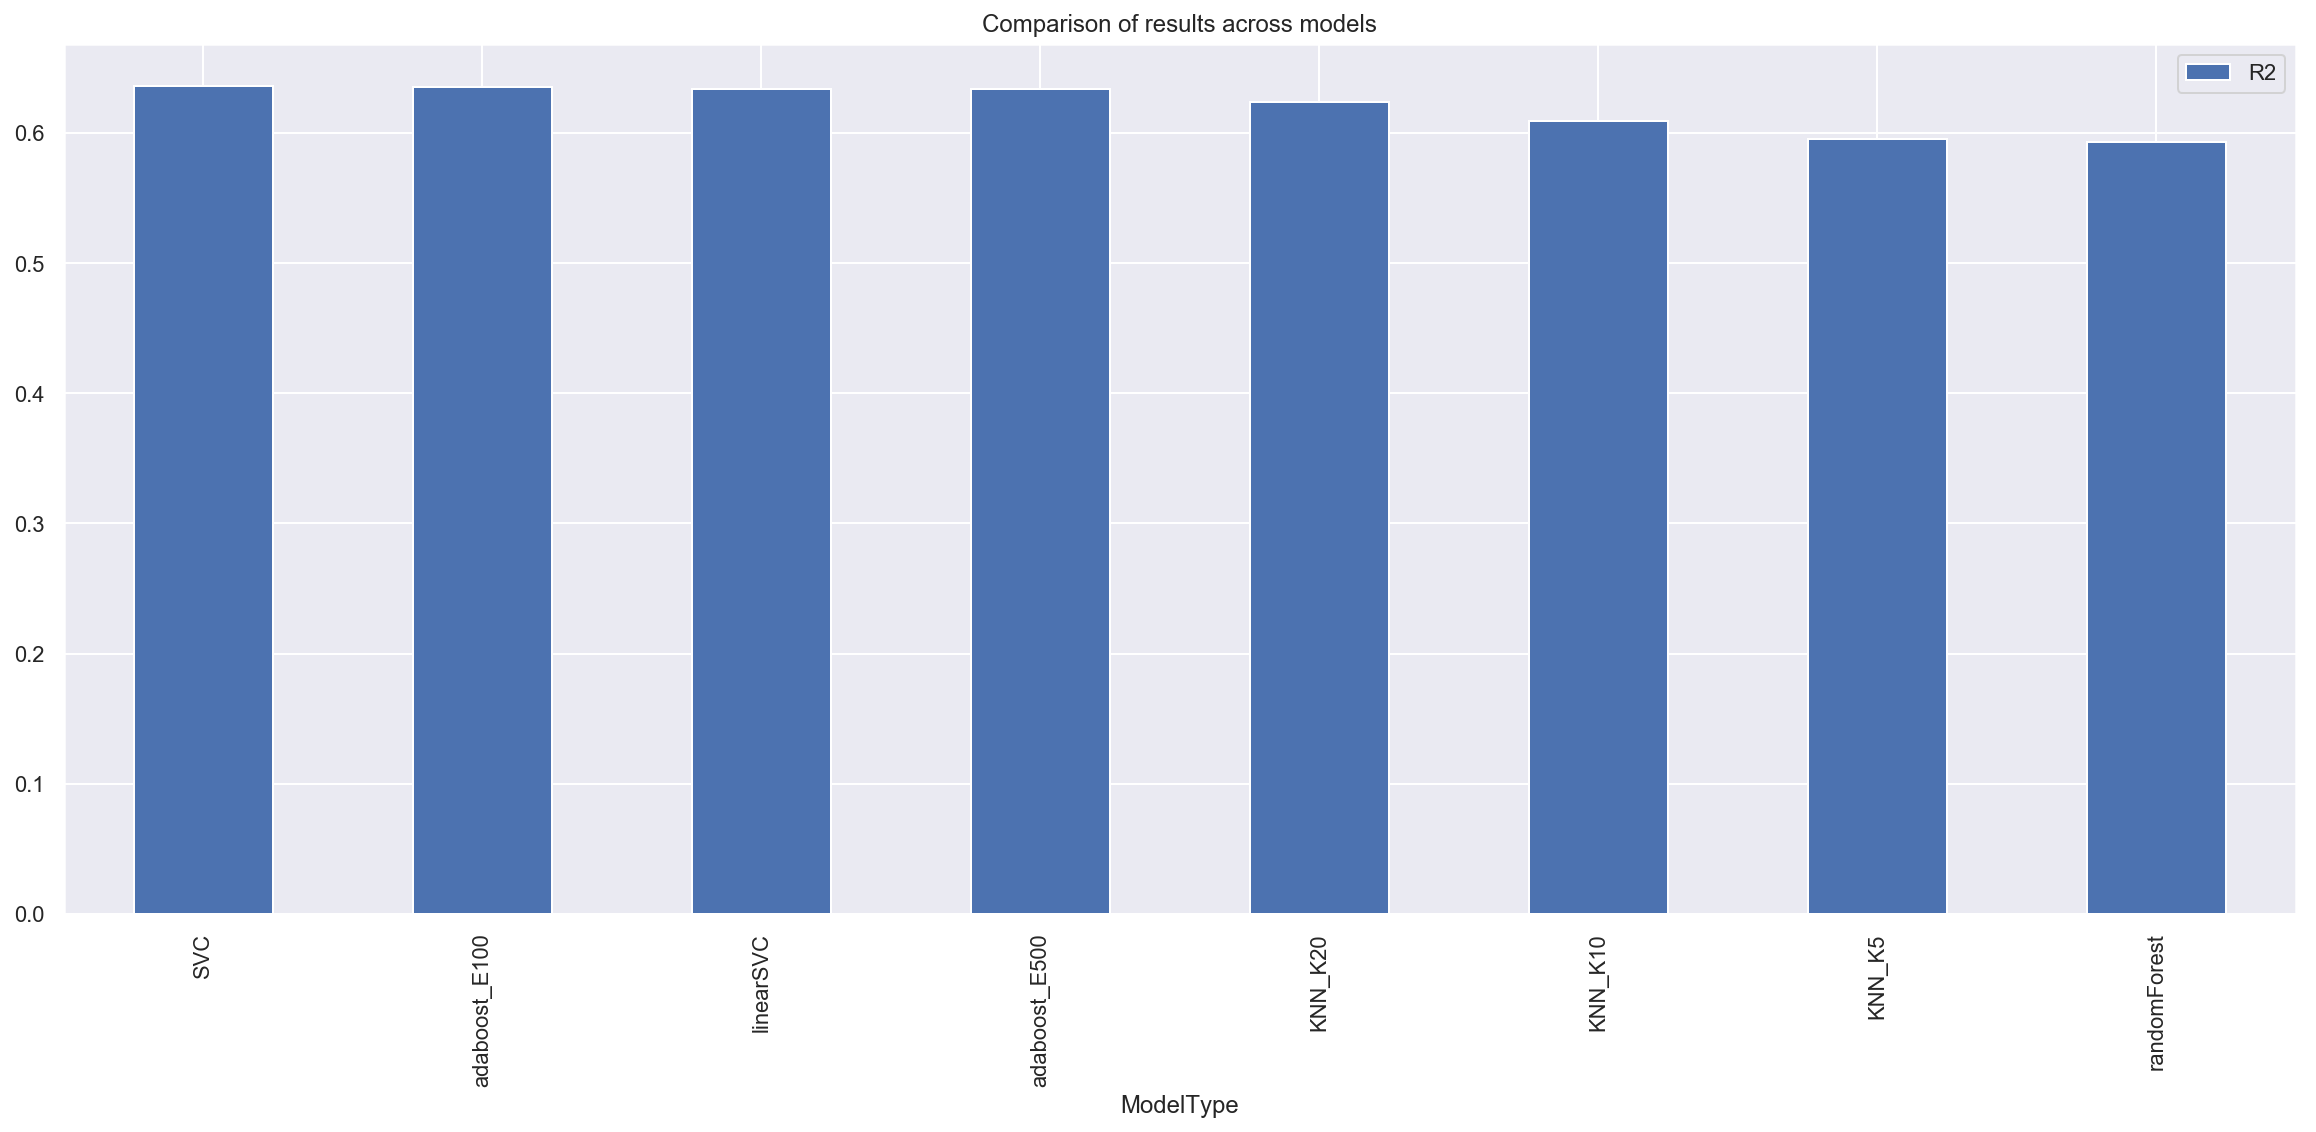

In [136]:
df_R2[['ModelType','R2']].groupby(by='ModelType').max().sort_values(by='R2', ascending=False).plot(kind='bar', title='Comparison of results across models');

<div class="alert alert-info" style="font-size:150%">From the graph above, we can see that SVC model gave us the best results (0.636) which is higher than the baseline of 0.5 (highest percentage of label in the same class). </div>

<div class="alert alert-info" style="font-size:100%">Q: In this context, would you use mean squared error, median squared error, mean absolute error or median absolute error to evaluate the models? Explain pros/cons of the different metrics.<br/>A: As we are using classification methods, confusion matrix and F1 scores / recall / recall will be a better metric in order for us to know whether predictions accuracies are acceptable for the 4 quadrant (True Positive, False Positive, False Negative, True Negative)</div>

              precision    recall  f1-score   support

           0       0.65      0.66      0.66      5031
           1       0.64      0.64      0.64      4880

   micro avg       0.65      0.65      0.65      9911
   macro avg       0.65      0.65      0.65      9911
weighted avg       0.65      0.65      0.65      9911



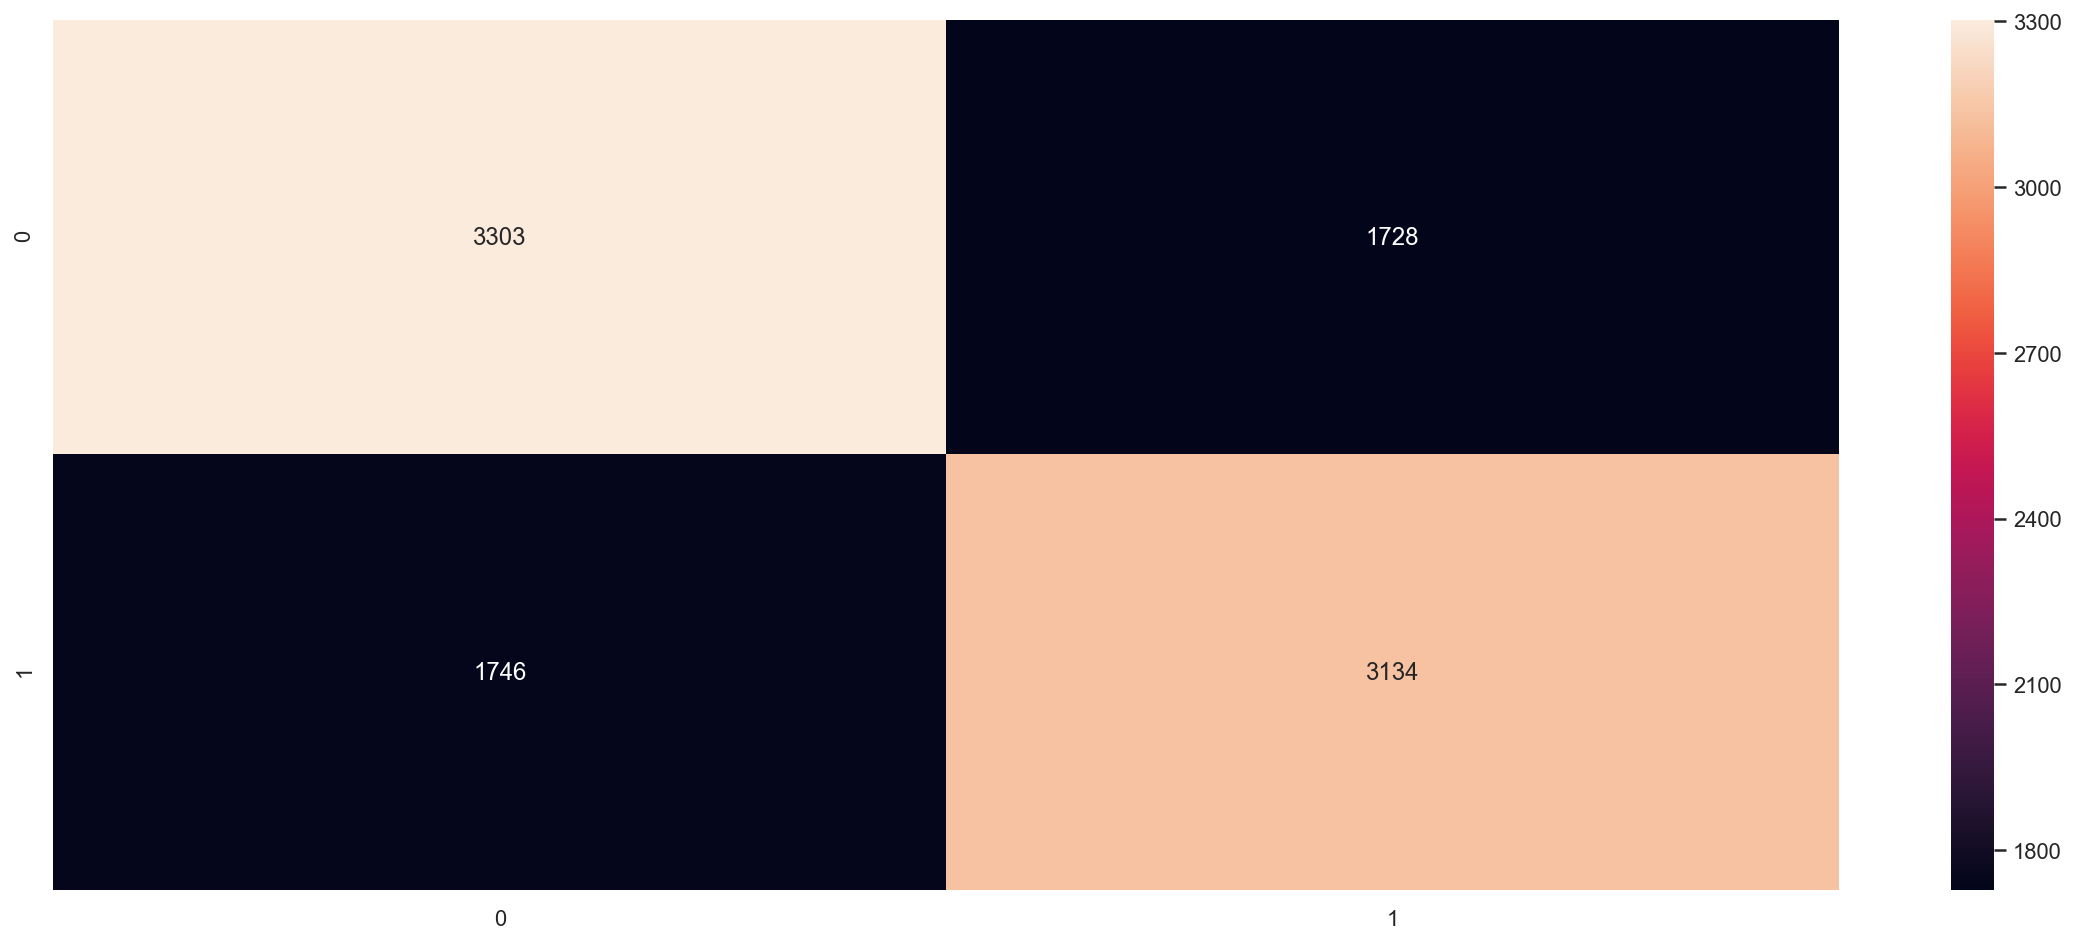

,score
kw_avg_avg,0.20
kw_max_avg,0.17
self_reference_avg_sharess,0.11
self_reference_min_shares,0.19
self_reference_max_shares,0.07
data_channel_is_world,0.04
LDA_02,0.17
is_weekend,0.02
data_channel_is_entertainment,0.02
data_channel_is_socmed,0.01


In [162]:
# as SVC doesnt have feature importance, we use adaboost (2nd highest, very close to highest score).
# rb	10	adaboost_E100
def top_model(X, y, scaler_name):
    from sklearn.ensemble import AdaBoostClassifier
    from sklearn.model_selection import cross_val_score
    from sklearn.model_selection import train_test_split
    from sklearn.metrics import confusion_matrix, classification_report
    import seaborn as sns
    
    X = normalise_predictors(X, scaler_name)
    X_train, X_test, y_train, y_test  = train_test_split(X, y)
    
    model = AdaBoostClassifier(n_estimators = 100)
    model.fit(X_train, y_train)
    y_predict = model.predict(X_test)
    cm = confusion_matrix(y_test, y_predict)
    plt.figure(figsize=(20,8))
    sns.heatmap(cm, annot = True, fmt='.0f')
    print(classification_report(y_test, y_predict))
    plt.show()
    return model.feature_importances_

feature_importance = pd.DataFrame(top_model(df_predictors[predictors_t10], df_targets['target_p50'], 'rb'), predictors_t10, columns=['score'])
feature_importance

In [153]:
feature_importance.sort_values(by='score', ascending=False).head()

,score
LDA_02,0.24
kw_avg_avg,0.21
kw_max_avg,0.15
self_reference_min_shares,0.12
self_reference_max_shares,0.11


<div class="alert alert-info" style="font-size:100%"><b>LDA_02</b>, <b>kw_avg_avg</b>, <b>kw_max_avg</b> are the most important features in determining the share count. From a business perspective, businesses can try to increase their share count by focusing on optimising these values. </div>